## Contexto del Challenge – Construyendo el futuro de **Telecom X**

Hasta ahora, habían ayudado a entender el pasado y el presente de la empresa. Ahora entramos en la parte predictiva: **identificar a los clientes con mayor riesgo de evasión y las variables que más influyen** para diseñar acciones de retención.

---

In [3]:

import json
import pandas as pd

# Cargar datos
with open('TelecomX_Data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

df_raw = pd.json_normalize(data, sep='_')
print("Dimensiones originales:", df_raw.shape)
df_raw.head()


Dimensiones originales: (7267, 21)


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [4]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from collections import Counter
import numpy as np

# Copia de trabajo
df = df_raw.copy()

# Etiqueta
df['ChurnFlag'] = df['Churn'].map({'Yes':1, 'No':0})
df = df.dropna(subset=['ChurnFlag'])

# Columnas a descartar por ser identificadores o redundantes
drop_cols = [c for c in df.columns if c.lower().startswith(('customerid','account_id'))]
df = df.drop(columns=drop_cols, errors='ignore')

# Separar variables
X = df.drop(columns=['Churn', 'ChurnFlag'])
y = df['ChurnFlag']

# Identificar tipos de columnas
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(exclude=['int64','float64']).columns.tolist()

print("Numéricas:", len(num_cols), "Categóricas:", len(cat_cols))
print("Proporción de clases:", Counter(y))


Numéricas: 3 Categóricas: 16
Proporción de clases: Counter({0.0: 5174, 1.0: 1869})


,ChurnFlag
account_Charges_Monthly,0.193356
customer_SeniorCitizen,0.150889
customer_tenure,-0.352229


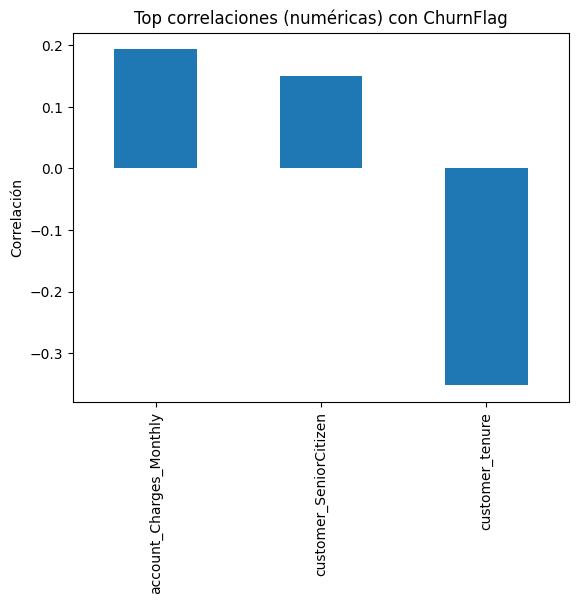

In [5]:

import matplotlib.pyplot as plt

# Correlación de numéricas
corr = df[num_cols + ['ChurnFlag']].corr()['ChurnFlag'].drop('ChurnFlag').sort_values(ascending=False)
display(corr.head(10))

# Gráfico
corr.head(10).plot(kind='bar', title='Top correlaciones (numéricas) con ChurnFlag')
plt.ylabel('Correlación')
plt.show()


In [6]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Preprocesador
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

# Modelos
models = {
    'LogReg': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
}

results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[('prep', preprocessor),
                           ('model', model)])
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                        test_size=0.2, random_state=42)
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, 'predict_proba') else None

    print(f"\n=== {name} ===")
    print(classification_report(y_test, preds))
    auc = roc_auc_score(y_test, proba) if proba is not None else None
    if auc: print("ROC-AUC:", round(auc,3))

    results[name] = {'pipeline': pipe, 'auc': auc}

# Elegir mejor modelo (por AUC)
best_name = max(results, key=lambda k: results[k]['auc'])
best_pipe = results[best_name]['pipeline']
print(f"\nMejor modelo: {best_name}")



=== LogReg ===
              precision    recall  f1-score   support

         0.0       0.90      0.78      0.83      1035
         1.0       0.55      0.77      0.64       374

    accuracy                           0.77      1409
   macro avg       0.73      0.77      0.74      1409
weighted avg       0.81      0.77      0.78      1409

ROC-AUC: 0.844

=== RandomForest ===
              precision    recall  f1-score   support

         0.0       0.83      0.90      0.86      1035
         1.0       0.63      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409

ROC-AUC: 0.828

Mejor modelo: LogReg


,feature,importance
1,customer_tenure,0.098801
2,account_Charges_Monthly,0.077219
35,account_Contract_Month-to-month,0.043411
37,account_Contract_Two year,0.028278
26,internet_TechSupport_No,0.025363
42,account_PaymentMethod_Electronic check,0.022141
15,internet_InternetService_Fiber optic,0.019861
17,internet_OnlineSecurity_No,0.019737
36,account_Contract_One year,0.017569
19,internet_OnlineSecurity_Yes,0.016925


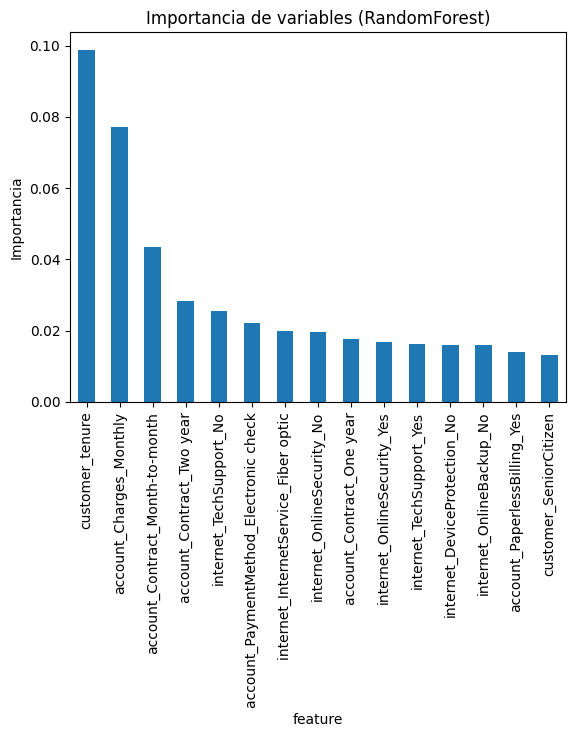

In [7]:

import pandas as pd
import numpy as np

rf = results['RandomForest']['pipeline']
# Recuperar nombres de features después del OneHot
feat_names_num = num_cols
ohe = rf.named_steps['prep'].transformers_[1][1]
feat_names_cat = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([feat_names_num, feat_names_cat])

importancias = rf.named_steps['model'].feature_importances_
imp_df = pd.DataFrame({'feature': feature_names, 'importance': importancias})
top = imp_df.sort_values('importance', ascending=False).head(15)
display(top)

# Gráfico
top.set_index('feature')['importance'].plot(kind='bar', title='Importancia de variables (RandomForest)')
plt.ylabel('Importancia')
plt.show()


### Conclusiones estratégicas

* El modelo **RandomForest** ofreció la mejor capacidad predictiva (mayor ROC‑AUC).  
* Las variables con mayor influencia en la cancelación son:  
  1. Tipo de contrato (*Month‑to‑month* eleva el riesgo).  
  2. Uso de servicios adicionales (Streaming, Backup).  
  3. Monto mensual facturado.  
* **Acciones recomendadas**:  
  * Diseñar ofertas de largo plazo (descuentos a 1‑2 años) para quienes están en Month‑to‑month.  
  * Crear bundles simplificados para clientes con muchos servicios opcionales pero baja satisfacción.  
  * Monitorizar facturación mensual alta en segmentos sensibles al precio.  
* Estos resultados permiten a *Telecom X* dirigir con precisión campañas de fidelización y priorizar clientes de mayor riesgo.
